Загружаем нужные библиотеки

In [1]:
import pandas as pd
import openpyxl as op
import numpy as np
from itertools import islice
import requests
from bs4 import BeautifulSoup
import os
import nltk
import pymorphy2
import nltk.corpus
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

Загружаем данные

In [2]:
urls = op.load_workbook(r'C:\Users\HP\Notebooks\Семестр2\Проект\all_urls.xlsx');
sheet = urls.get_sheet_by_name('Sheet1');
data = sheet.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df = pd.DataFrame(data, index=idx, columns=cols)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  


In [3]:
df.head()

,Search Engine,IDRequest,URL page
0,Google,0,https://www.google.com/imgres?imgurl=https://u...
1,Google,0,https://www.google.com/imgres?imgurl=http://az...
2,Google,0,https://www.google.com/imgres?imgurl=https://g...
3,Google,0,https://www.google.com/imgres?imgurl=https://i...
4,Google,0,https://www.google.com/url?q=https://ru.wikipe...


Добавляем столбец кода страницы. Это поможет исключить неработающие ссылки

In [17]:
df['Status_code'] = -1

In [173]:
df.head()

,Search Engine,IDRequest,URL page,Text,Status_code,KMeans
0,Google,0,https://www.google.com/imgres?imgurl=https://u...,empty,200,0
1,Google,0,https://www.google.com/imgres?imgurl=http://az...,empty,200,0
2,Google,0,https://www.google.com/imgres?imgurl=https://g...,empty,200,0
3,Google,0,https://www.google.com/imgres?imgurl=https://i...,empty,200,0
4,Google,0,https://www.google.com/url?q=https://ru.wikipe...,empty,200,0


## Требуемые методы 

Метод для получения текста из указанного тега

In [22]:
def getTextByTag(tag, soup):
    str = ""
    tags = soup.find_all(tag)
    for elem in tags:
        str = "{0}\n{1}".format(str, elem.getText())
    return str

Метод для получения 15 наиболее частых слов в тексе. 

Предварительно из тексат удаляются незначащие слова(например, предлоги) и знаки препинания. 

Далее происходит лемманизация слов, то есть все слова преобразовываются в свои корневые слова(корня -> корень)

In [23]:
def getMostCommonWords(text):
    pymorphy = pymorphy2.MorphAnalyzer()
    a = set(stopwords.words('russian'))
    words = {':', '.', ',', '(', ')', '—', '«', '»', 'это', 'всё', '!', '?', 'эта', 'нам', 'оно', '-', "''", ';', '--', '``',
            '[', ']', '{', '}', '*', '...', '↑', '//'}
    a.update(words)
    text1 = word_tokenize(text.lower())
    words = [x for x in text1 if x not in a]  
    for i in range(len(words)):
        words[i] = pymorphy.parse(words[i])[0].normal_form
    fdist = FreqDist(words)
    return fdist.most_common(15)

Список всех тегов, в которых может быть текст

Тег **em** предназначен для акцентирования текста.

Тег **plaintext** отображает содержимое контейнера «как есть».

Тег **abbr** указывает, что последовательность символов является аббревиатурой.

Тег **acronym** сообщает, что текст является акронимом. 

Тег **address** предназначен для хранения информации об авторе

Тег **b** устанавливает жирное начертание шрифта.

Тег **blockquote** предназначен для выделения длинных цитат внутри документа.

Тег **h5** задает заголовок пятого уровня.

In [24]:
tags = ['p', 'em', 'dd', 'plaintext', 'pre', 'blockquote', 'b', 'abbr', 'acronym', 'address', 'cite', 'ruby', 'rp', 'h2', 'li']

Метод для добавления пустой строки в выборку. Для страниц, которые не доступны по каким-либо причинам

In [25]:
def setEmptyRow(df):
    ser = {}
    for i in range(15): 
        ser.update({str(i + 1): np.nan})
    return df.append(ser, ignore_index=True)

Метод для сбора часто встречающихся слов

In [175]:
def getInformation(index, df, mostCommonWords):
    try:
        page = requests.get(df['URL page'][index]) 
        if(page.encoding == 'ISO-8859-1'):
            page.encoding = 'cp1251'
    except:
        print('HTTPConnection Error')
        mostCommonWords = setEmptyRow(mostCommonWords)
        return mostCommonWords
    soup = BeautifulSoup(page.text)
    df['Status_code'][index] = page.status_code
    if(page.status_code != 200):
        ser = {}
        mostCommonWords = setEmptyRow(mostCommonWords)
        return mostCommonWords
    text = ''
    for i in range(len(tags)):
        text = getTextByTag(tags[i], soup)
        if(text != None and text != ''):
            df['Text'][index] = text
            commonWords = getMostCommonWords(text)
            ser = {}
            for i in range(len(commonWords)): 
                ser.update({str(i + 1): commonWords[i][0]})
            mostCommonWords = mostCommonWords.append(ser, ignore_index=True)
            return mostCommonWords
    mostCommonWords = setEmptyRow(mostCommonWords)
    return mostCommonWords

Выборка для часто встречающихся слов

In [176]:
mostCommonWords = pd.DataFrame(columns=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])
mostCommonWords

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15


# Получение выборки часто встречаемых слов

In [177]:
for i in range(len(df)):
    print(i)
    mostCommonWords = getInformation(i, df, mostCommonWords)

0


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
HTTPConnection Error
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
HTTPConnection Error
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
HTTPConnection Error
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
HTTPConnection Error
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256


2020-04-03 19:21:24,185 : ERROR : Certificate did not match expected hostname: vrach-pediatr.ru. Certificate: {'subject': ((('commonName', 'platiuslugi.ru'),),), 'subjectAltName': [('DNS', 'platiuslugi.ru'), ('DNS', 'www.platiuslugi.ru')]}


HTTPConnection Error
492
493
494
495
496
497
498
499
HTTPConnection Error
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
HTTPConnection Error
537
538
539
540
541
542
543
544
HTTPConnection Error
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
HTTPConnection Error
573
574
575
576
577
578
579
580
HTTPConnection Error
581
582
583
584
HTTPConnection Error
585
586
587


2020-04-03 19:24:23,867 : ERROR : Certificate did not match expected hostname: www.iske-kazan.ru. Certificate: {'subject': ((('commonName', 's12.webhost1.ru'),),), 'subjectAltName': [('DNS', 's12.webhost1.ru')]}


588
HTTPConnection Error
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
HTTPConnection Error
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674


2020-04-03 19:26:04,482 : ERROR : Certificate did not match expected hostname: www.iske-kazan.ru. Certificate: {'subject': ((('commonName', 's12.webhost1.ru'),),), 'subjectAltName': [('DNS', 's12.webhost1.ru')]}


675
HTTPConnection Error
676
677
678
679
HTTPConnection Error
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
HTTPConnection Error
706
707
708
709
710
711
712
713
714
715
716
717
718
719
HTTPConnection Error
720
721
722
723
724
725
726
727
728
729
730
731
HTTPConnection Error
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
HTTPConnection Error
765
766
767
768
769
770
771
772
HTTPConnection Error
773
774
HTTPConnection Error
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
HTTPConnection Error
801
802
803
804
805
806
807
808
HTTPConnection Error
809
810
811
812
HTTPConnection Error
813
814
815


2020-04-03 19:30:13,202 : ERROR : Certificate did not match expected hostname: www.iske-kazan.ru. Certificate: {'subject': ((('commonName', 's12.webhost1.ru'),),), 'subjectAltName': [('DNS', 's12.webhost1.ru')]}


816
HTTPConnection Error
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
HTTPConnection Error
853
854
855
856
857
858
859
860
861
HTTPConnection Error
862
863
864
865
HTTPConnection Error
866
867
HTTPConnection Error
868
869
870
871
872
873
HTTPConnection Error
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
HTTPConnection Error
904
HTTPConnection Error
905
906
907
908
909
910
911
912
913
914
915
HTTPConnection Error
916
917
918
919
920
921
922
923
924
925
926
927
HTTPConnection Error
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
HTTPConnection Error
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
100

2020-04-03 19:37:54,444 : ERROR : Certificate did not match expected hostname: www.iske-kazan.ru. Certificate: {'subject': ((('commonName', 's12.webhost1.ru'),),), 'subjectAltName': [('DNS', 's12.webhost1.ru')]}


1088
HTTPConnection Error
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283

In [13]:
len(mostCommonWords)

1310

Данные

In [14]:
mostCommonWords

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,каменеть,гавриил,пётр,википедия,ru.wikipedia.org,изображение,мочь,защитить,авторский,право,NaN,NaN,NaN,NaN,NaN
1,каменеть,lib.ru/классика,гавриил,пётр,г.,п.,az.lib.ru,изображение,мочь,защитить,авторский,право,NaN,NaN,NaN
2,гавриил,каменеть,позабыть,весь,вселенная,год,литература,godliteratury.ru,изображение,мочь,защитить,авторский,право,NaN,NaN
3,поэт,гавриил,каменеть,1772-1803,youtube,youtube.com,изображение,мочь,защитить,авторский,право,NaN,NaN,NaN,NaN
4,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
5,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
6,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
7,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
8,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
9,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.


Выгружаем выборку

In [15]:
mostCommonWords.to_excel('Most_commom_words.xlsx')

In [3]:
urls = op.load_workbook(r'C:\Users\HP\Notebooks\Семестр2\Проект\Most_commom_words.xlsx');
sheet = urls.get_sheet_by_name('Sheet1');
data = sheet.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
mostCommonWords = pd.DataFrame(data, index=idx, columns=cols)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  


# Использование методов кластеризации

In [5]:
mostCommonWords.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,каменеть,гавриил,пётр,википедия,ru.wikipedia.org,изображение,мочь,защитить,авторский,право,None,None,None,None,None
1,каменеть,lib.ru/классика,гавриил,пётр,г.,п.,az.lib.ru,изображение,мочь,защитить,авторский,право,None,None,None
2,гавриил,каменеть,позабыть,весь,вселенная,год,литература,godliteratury.ru,изображение,мочь,защитить,авторский,право,None,None
3,поэт,гавриил,каменеть,1772-1803,youtube,youtube.com,изображение,мочь,защитить,авторский,право,None,None,None,None
4,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.


Удаляем пустые строки

In [6]:
df1 = mostCommonWords.dropna(axis=0)
df1.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
4,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
5,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
6,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
7,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
8,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.


Метод для перевода текста в число

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def categoric(data):
    categorical_columns = data.columns[data.dtypes == 'object']
    for column in categorical_columns:
        data[column] = le.fit_transform(data[column])
    return data

Метод для стандартизации данных

In [8]:
from sklearn import preprocessing
def standart(data):
    for column in data.columns:
        data[column] = preprocessing.scale(data[column])
    return data;

## Стандартизуем данные

In [82]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 4 to 1309
Data columns (total 15 columns):
1     1038 non-null float64
2     1038 non-null float64
3     1038 non-null float64
4     1038 non-null float64
5     1038 non-null float64
6     1038 non-null float64
7     1038 non-null float64
8     1038 non-null float64
9     1038 non-null float64
10    1038 non-null float64
11    1038 non-null float64
12    1038 non-null float64
13    1038 non-null float64
14    1038 non-null float64
15    1038 non-null float64
dtypes: float64(15)
memory usage: 129.8 KB


In [83]:
df1 = categoric(df1)

In [84]:
df1.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
4,-0.065729,0.628774,0.207578,-0.800502,-0.246189,0.83805,-0.309233,-1.427642,-0.942308,-0.262754,-0.779405,1.091681,-0.549055,-0.617698,-0.927157
5,-0.065729,0.628774,0.207578,-0.800502,-0.246189,0.83805,-0.309233,-1.427642,-0.942308,-0.262754,-0.779405,1.091681,-0.549055,-0.617698,-0.927157
6,-0.065729,0.628774,0.207578,-0.800502,-0.246189,0.83805,-0.309233,-1.427642,-0.942308,-0.262754,-0.779405,1.091681,-0.549055,-0.617698,-0.927157
7,-0.065729,0.628774,0.207578,-0.800502,-0.246189,0.83805,-0.309233,-1.427642,-0.942308,-0.262754,-0.779405,1.091681,-0.549055,-0.617698,-0.927157
8,-0.065729,0.628774,0.207578,-0.800502,-0.246189,0.83805,-0.309233,-1.427642,-0.942308,-0.262754,-0.779405,1.091681,-0.549055,-0.617698,-0.927157


In [85]:
df1 = standart(df1)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [86]:
df1.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
4,-0.065729,0.628774,0.207578,-0.800502,-0.246189,0.83805,-0.309233,-1.427642,-0.942308,-0.262754,-0.779405,1.091681,-0.549055,-0.617698,-0.927157
5,-0.065729,0.628774,0.207578,-0.800502,-0.246189,0.83805,-0.309233,-1.427642,-0.942308,-0.262754,-0.779405,1.091681,-0.549055,-0.617698,-0.927157
6,-0.065729,0.628774,0.207578,-0.800502,-0.246189,0.83805,-0.309233,-1.427642,-0.942308,-0.262754,-0.779405,1.091681,-0.549055,-0.617698,-0.927157
7,-0.065729,0.628774,0.207578,-0.800502,-0.246189,0.83805,-0.309233,-1.427642,-0.942308,-0.262754,-0.779405,1.091681,-0.549055,-0.617698,-0.927157
8,-0.065729,0.628774,0.207578,-0.800502,-0.246189,0.83805,-0.309233,-1.427642,-0.942308,-0.262754,-0.779405,1.091681,-0.549055,-0.617698,-0.927157


### Дендограмма

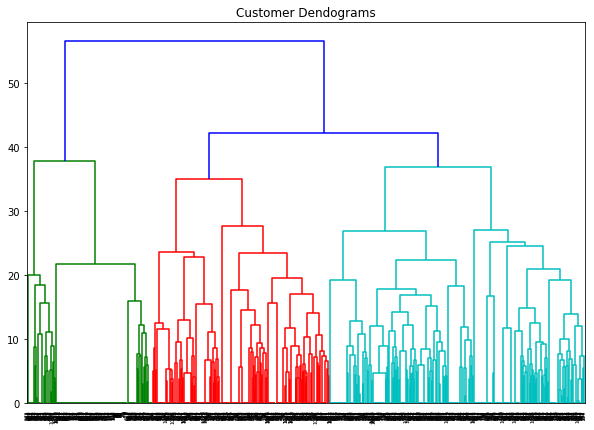

In [28]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(df1, method='ward'))

Метод определил 3 класса

### Метод KMeans

In [87]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(df1)
y_kmeans = kmeans.predict(df1)
y_kmeans

array([1, 1, 1, ..., 0, 0, 1])

In [88]:
unique, counts = np.unique(y_kmeans, return_counts=True)
dictc = dict(zip(unique, counts))

In [89]:
dictc

{0: 386, 1: 289, 2: 363}

In [90]:
clusters = pd.DataFrame(columns=['Method', '1', '2', '3'])
clusters = clusters.append({'Method': 'KMeans_standart', '1': dictc[0], '2': dictc[1], '3': dictc[2]}, ignore_index=True)

In [16]:
urls = op.load_workbook(r'C:\Users\HP\Notebooks\Семестр2\Проект\Clustered.xlsx');
sheet = urls.get_sheet_by_name('Sheet1');
data = sheet.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
cluster = pd.DataFrame(data, index=idx, columns=cols)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  


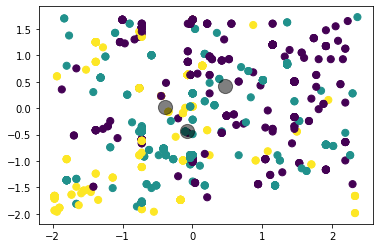

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(df1.iloc[:, 0], df1.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### DBSCAN

In [91]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=26)
dbscan.fit(df1)

DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=26, n_jobs=None, p=None)

In [92]:
dbscan.labels_

array([ 0,  0,  0, ..., -1, -1, -1], dtype=int64)

In [93]:
unique, counts = np.unique(dbscan.labels_, return_counts=True)
dic = dict(zip(unique, counts))
dic

{-1: 873, 0: 134, 1: 31}

In [94]:
clusters = clusters.append({'Method': 'DBSCAN_standart', '1': dic[-1], '2': dic[0], '3': dic[1]}, ignore_index=True)

Можно предположить, что к классу -1 относится биография, к классу 0 - стихотворения и к классу 1 - дркгие сайты, в том числе ошибочные

Добавляем в выборку значения NAN, соответсвующие ошибочным сайтам

In [235]:
mostCommonWords2 = mostCommonWords.dropna(axis=0)
mostCommonWords2['Cluster'] = dbscan.labels_

indexes = mostCommonWords2.index
length = len(mostCommonWords)
missed_index = []
for i in range(length):
    if i not in indexes:
        missed_index.append(i)
        
for i in missed_index:
    s = pd.Series()
    s.name = i
    mostCommonWords2 = mostCommonWords2.append(s)

mostCommonWords2 = mostCommonWords2.sort_index()
mostCommonWords2.head()

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Cluster
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.,0.0


Добавляем результаты как отдельный столбец

In [237]:
df['DBScanStandart'] = mostCommonWords2['Cluster']

In [44]:
df.head(10)

,Search Engine,IDRequest,URL page,Status_code,DBScanStandart
0,Google,0,https://www.google.com/imgres?imgurl=https://u...,200,NaN
1,Google,0,https://www.google.com/imgres?imgurl=http://az...,200,NaN
2,Google,0,https://www.google.com/imgres?imgurl=https://g...,200,NaN
3,Google,0,https://www.google.com/imgres?imgurl=https://i...,200,NaN
4,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0
5,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0
6,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0
7,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0
8,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0
9,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0


# Перевод данных в числовые

In [95]:
df2 = mostCommonWords.dropna(axis=0)
df2.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
4,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
5,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
6,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
7,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.
8,казань,поэт,один,год,каменеть,свой,каменев,.mw-parser-output,время,казанский,дочь,стать,иван,её,г.


In [96]:
df2 = categoric(df2)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [97]:
df2.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
4,55,105,97,44,78,146,86,3,43,86,57,187,78,71,48
5,55,105,97,44,78,146,86,3,43,86,57,187,78,71,48
6,55,105,97,44,78,146,86,3,43,86,57,187,78,71,48
7,55,105,97,44,78,146,86,3,43,86,57,187,78,71,48
8,55,105,97,44,78,146,86,3,43,86,57,187,78,71,48


### Дендограмма

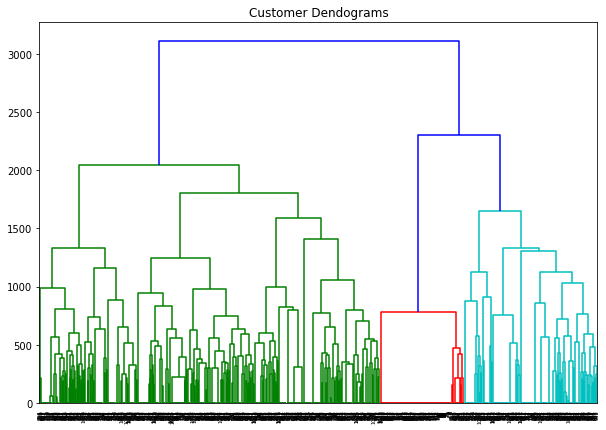

In [50]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(df2, method='ward'))

Метод определил 3 класса

### Метод KMeans

In [98]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(df2)
y_kmeans = kmeans.predict(df2)
y_kmeans

array([2, 2, 2, ..., 1, 1, 0])

In [99]:
unique, counts = np.unique(y_kmeans, return_counts=True)
dic = dict(zip(unique, counts))
dic

{0: 460, 1: 367, 2: 211}

In [100]:
clusters = clusters.append({'Method': 'KMeans', '1': dic[0], '2': dic[1], '3': dic[2]}, ignore_index=True)

In [41]:
cluster.head()

,Search Engine,IDRequest,URL page,Text,Status_code,KMeans,SVDKMeans,DBScanStandart,DBScanCat,MCWKMeans,MCWKMeans2
0,Google,0,None,"\nКаменев, Гавриил Петрович — Википедия\nru.wi...",200,0,0,NaN,NaN,NaN,NaN
1,Google,0,None,\nLib.ru/Классика: Каменев Гавриил Петрович. Г...,200,0,0,NaN,NaN,NaN,NaN
2,Google,0,None,\nГавриил Каменев. «Позабыт я всей вселенной» ...,200,0,0,NaN,NaN,NaN,NaN
3,Google,0,None,\nПоэт Гавриил Каменев 1772-1803 - YouTube\nyo...,200,0,0,NaN,NaN,NaN,NaN
4,Google,0,None,\nГаврии́л (Гаври́ла) Петро́вич Ка́менев (1773...,200,0,0,0.0,0.0,1.0,0.0


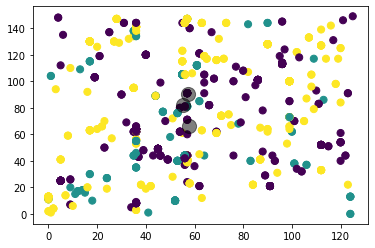

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(df2.iloc[:, 0], df2.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### DBSCAN

In [102]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=26)
dbscan.fit(df2)

DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=26, n_jobs=None, p=None)

In [103]:
dbscan.labels_

array([ 0,  0,  0, ..., -1, -1, -1], dtype=int64)

In [104]:
unique, counts = np.unique(dbscan.labels_, return_counts=True)
dic = dict(zip(unique, counts))
dic

{-1: 873, 0: 134, 1: 31}

In [105]:
clusters = clusters.append({'Method': 'DBSCAN', '1': dic[-1], '2': dic[0], '3': dic[1]}, ignore_index=True)

Можно предположить, что к классу -1 относится биография, к классу 0 - стихотворения и к классу 1 - дркгие сайты, в том числе ошибочные

Добавляем в выборку значения NAN, соответсвующие ошибочным сайтам

Как видим, разницы с предыдущим решением нет

In [246]:
mostCommonWords2 = mostCommonWords.dropna(axis=0)
mostCommonWords2['Cluster'] = dbscan.labels_
indexes = mostCommonWords2.index
length = len(mostCommonWords)
missed_index = []
for i in range(length):
    if i not in indexes:
        missed_index.append(i)
for i in missed_index:
    s = pd.Series()
    s.name = i
    mostCommonWords2 = mostCommonWords2.append(s)
mostCommonWords2 = mostCommonWords2.sort_index()
df['DBScanCat'] = mostCommonWords2['Cluster']

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [59]:
df.head(10)

,Search Engine,IDRequest,URL page,Status_code,DBScanStandart,DBScanCat
0,Google,0,https://www.google.com/imgres?imgurl=https://u...,200,NaN,NaN
1,Google,0,https://www.google.com/imgres?imgurl=http://az...,200,NaN,NaN
2,Google,0,https://www.google.com/imgres?imgurl=https://g...,200,NaN,NaN
3,Google,0,https://www.google.com/imgres?imgurl=https://i...,200,NaN,NaN
4,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0,0.0
5,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0,0.0
6,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0,0.0
7,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0,0.0
8,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0,0.0
9,Google,0,https://www.google.com/url?q=https://ru.wikipe...,200,0.0,0.0


# Тематическое моделирование

Тематическое моделирование – это метод извлечения тем из текста. Latent Dirichlet Allocation (LDA) – популярный алгоритм моделирования тем реализованные в том числе в пакете Gensim. Основная задача алгоритмов ТМ, заключается в том что бы полученные темы были хорошего качество, понятными, самозначимыми и разделенными. Достижение этих целей во многом зависит от качества предварительной обработки текста и стратегии поиска оптимального количества тем.

Подход LDA к тематическому моделированию заключается в том, что каждый документ рассматривается как набор тем в определенной пропорции. И каждая тема как набор ключевых слов, опять же, в определенной пропорции.

После того, как вы укажете алгоритму количество тем, все, что он сделает, – это отобразит распределение тем в документах и распределение ключевых слов по темам.

Тема – это не что иное, как набор доминирующих ключевых слов. Просто взглянув на ключевые слова, вы сможете определить, о чем эта тема.

Ниже приведены ключевые факторы для получения хороших разделительных тем:

* Качество обработки текста.
* Разнообразие тем, о которых говорится в тексте.
* Выбор алгоритма моделирование тем.
* Количество тем, указанных в алгоритме.
* Алгоритмы настройки параметров.

In [49]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pprint import pprint

import spacy

import pyLDAvis
import pyLDAvis.gensim

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Получаем список текстов

In [47]:
data = df.Text.values.tolist()

#### Токенизация слов и очистка текста

Разбиваем каждый текст на отдельные слова, исключая знаки пунктуации

In [50]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(sent_to_words(data))
print(data_words[:1])

[['каменев', 'гавриил', 'петрович', 'википедия', 'ru', 'wikipedia', 'org', 'изображения', 'могут', 'быть', 'защищены', 'авторским', 'правом']]


#### Создание биграмм и триграмм

Биграммы – это два слова, часто встречающиеся в документе вместе. Триграммы – это 3 часто встречающихся слова вместе.

Модель фраз Gensim может создавать и реализовывать биграммы, триграммы, квадрограммы и многое другое. Двумя важными аргументами фраз являются min_count и threshold. Чем выше значения этих параметров, тем сложнее объединить слова в биграммы.

In [51]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['каменев', 'гавриил_петрович', 'википедия', 'ru_wikipedia_org', 'изображения_могут_быть', 'защищены_авторским_правом']


#### Удаление стоп-слов, создание биграмм и лемматизация

Определим методы для удаления стоп-слов, создания биграмм и лемматизации

In [52]:
a = set(stopwords.words('russian'))
words = {':', '.', ',', '(', ')', '—', '«', '»', '!', '?', '-', "''", ';', '--', '``',
            '[', ']', '{', '}', '*', '...', '↑', '//'}
a.update(words)
pymorphy = pymorphy2.MorphAnalyzer()
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in a] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts):
    texts_out = []
    for sent in texts:      
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

Последовательно удаляем стоп-слова, создаем биграммы и лемматизируем тексты

In [106]:
from spacy.lang.ru import Russian
from spacy_russian_tokenizer import RussianTokenizer, MERGE_PATTERNS
data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

In [107]:
russian_tokenizer = RussianTokenizer(nlp, MERGE_PATTERNS)
nlp.add_pipe(russian_tokenizer, name='russian_tokenizer')
data_lemmatized = lemmatization(data_words_bigrams)
print(data_lemmatized[:1])

[['каменев', 'гавриил', 'пётр', 'википедия', 'ru', 'wikipedia_org', 'изображения_мочь', 'защищены_авторским', 'правом']]


#### Создание словаря и корпуса

Двумя основными входными данными для тематической модели LDA являются словарь (id2word) и корпус

In [108]:
id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


Gensim создает уникальный идентификатор для каждого слова в документе.
Например, (0, 1) выше подразумевает, что слово c id 0 встречается один раз в первом документе.

#### Строим модель

В дополнение к корпусу и словарю необходимо также указать количество тем

Кроме того, **alpha** и **eta** являются гиперпараметрами, которые влияют на разреженность тем. Согласно документации Gensim, оба значения по умолчанию равны 1.0 / num_topics

**chunksize** – это количество документов, которые будут использоваться в каждом обучающем чанке 

**update_every** определяет, как часто параметры модели должны обновляться

**passes** – это общее количество проходов обучения.

In [109]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=10,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Посмотрим получившиеся темы

Каждая тема представляет собой комбинацию ключевых слов, и каждое ключевое слово вносит определенный вес в тему.

In [60]:
lda_model.print_topics()

[(0,
  '0.145*"_" + 0.144*"d" + 0.010*"каменев" + 0.006*"каменева" + 0.005*"гавриил" + 0.005*"пётр" + 0.004*"поэт" + 0.003*"казань" + 0.003*"громвал" + 0.003*"кн"'),
 (1,
  '0.007*"каменева" + 0.005*"каменев" + 0.005*"рѕр" + 0.005*"года" + 0.004*"ре" + 0.004*"это" + 0.003*"рі" + 0.003*"году" + 0.003*"сгс" + 0.003*"жизни"'),
 (2,
  '0.023*"каменев" + 0.017*"казани" + 0.013*"каменева" + 0.010*"года" + 0.010*"году" + 0.009*"поэта" + 0.008*"поэт" + 0.007*"казань" + 0.006*"это" + 0.005*"mw_parser"')]

Вероятности попадания текста в полученные темы

In [110]:
array = lda_model.get_topics()
array

array([[2.2443388e-04, 1.7842058e-06, 9.8427094e-04, ..., 1.7841426e-06,
        1.7841426e-06, 1.7841426e-06],
       [5.2733836e-04, 1.0173724e-06, 1.0388867e-06, ..., 5.0039384e-06,
        5.0039384e-06, 5.0039384e-06],
       [1.5875255e-04, 1.5216426e-04, 1.1703864e-04, ..., 1.6174545e-06,
        1.6174545e-06, 1.6174545e-06]], dtype=float32)

In [111]:
list = []
for i in range(len(data)):
    if array[0][i] >= array[1][i]:
        if array[0][i] >= array[2][i]:
            list.append(0)
        else:
            list.append(2)
    else:
        if array[1][i] >= array[2][i]:
            list.append(1)
        else:
            list.append(2)

In [112]:
cluster['LDA'] = list

In [117]:
clusters = clusters.append({'Method': 'LDA_Bigram', '1': top[2], '2': top[1], '3': top[0]}, ignore_index=True)

#### Вычисление сложности модели и ее когерентности

Cложность (Perplexity) модели и согласованность (Coherence) темы предоставляют удобную меру для оценки того, насколько хорошо выполнено тематическое моделирование. 

Чем меньше сложность, тем лучше

In [195]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.930537388578049

Coherence Score:  0.4612112093774305


#### Визуализация темы и ключевых слов

In [196]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

KeyboardInterrupt: 

#### Использование триграмм

In [118]:
data_words_trigrams = make_trigrams(data_words_nostops)

nlp = Russian()
russian_tokenizer = RussianTokenizer(nlp, MERGE_PATTERNS)
nlp.add_pipe(russian_tokenizer, name='russian_tokenizer')
data_lemmatized = lemmatization(data_words_trigrams)
print(data_lemmatized[:1])

id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[['каменев', 'гавриил_петр', 'википедия', 'ru_wikipedia_org', 'изображения_мочь', 'защищены_авторским_правом']]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [120]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=10,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [121]:
lda_model.print_topics()

[(0,
  '0.014*"каменев" + 0.012*"каменева" + 0.011*"года" + 0.008*"году" + 0.006*"казани" + 0.005*"это" + 0.005*"казань" + 0.003*"поэта" + 0.002*"время" + 0.002*"россии"'),
 (1,
  '0.133*"_" + 0.132*"d" + 0.009*"каменев" + 0.007*"рѕр" + 0.006*"ре" + 0.006*"каменева" + 0.005*"рі" + 0.005*"сгс" + 0.004*"гавриил_петр" + 0.004*"рер"'),
 (2,
  '0.023*"каменев" + 0.022*"казани" + 0.017*"каменева" + 0.014*"поэта" + 0.011*"поэт" + 0.010*"это" + 0.010*"году" + 0.007*"казань" + 0.006*"mw_parser_output_ts" + 0.005*"года"')]

In [162]:
array = lda_model.get_topics()
array

array([[1.2720377e-06, 3.8281079e-05, 7.1714376e-04, ..., 6.0719171e-06,
        6.0719171e-06, 6.0719171e-06],
       [2.6432745e-05, 3.7315171e-04, 4.1092108e-03, ..., 1.8354658e-06,
        1.8354658e-06, 1.8354658e-06],
       [2.2550738e-04, 2.8592758e-06, 1.4097738e-03, ..., 2.8591337e-06,
        2.8591337e-06, 2.8591337e-06]], dtype=float32)

In [123]:
list = []
for i in range(len(data)):
    if array[0][i] >= array[1][i]:
        if array[0][i] >= array[2][i]:
            list.append(0)
        else:
            list.append(2)
    else:
        if array[1][i] >= array[2][i]:
            list.append(1)
        else:
            list.append(2)

In [78]:
cluster['LDA_Trigrams'] = list

In [125]:
top = cluster['LDA_Trigrams'].value_counts()
top

0    1000
2     300
1      10
Name: LDA_Trigrams, dtype: int64

In [127]:
clusters = clusters.append({'Method': 'LDA_Trigram', '1': top[0], '2': top[2], '3': top[1]}, ignore_index=True)

#### Вычисление сложности модели и ее когерентности

In [79]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.193925324823264

Coherence Score:  0.4870883332521719


#### Визуализация темы и ключевых слов

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

# Кластеризация текста

Подготовим признаки, выделим частоты слов

## CountVectorizer

In [128]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(max_df=500, min_df=50)
matrix = vectorizer.fit_transform(data)

In [129]:
print(matrix.shape)

(1310, 2183)


### KMeans

In [131]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3, random_state=42)
pred = kmeans.fit_predict(matrix.toarray())

In [132]:
print(pred)

[0 0 0 ... 0 0 0]


In [133]:
df['KMeans'] = pred

In [134]:
df['KMeans'].value_counts()

0    1269
2      24
1      17
Name: KMeans, dtype: int64

In [135]:
top = df['KMeans'].value_counts()

In [136]:
clusters = clusters.append({'Method': 'KMeans_Text', '1': top[0], '2': top[2], '3': top[1]}, ignore_index=True)

### SVD + KMeans

Уменьшаем количество признаком, используя сингулярное разложение матриц

In [137]:
from sklearn.decomposition import TruncatedSVD

kmeans_model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=1000, random_state=42)
features = svd.fit_transform(matrix)
preds = kmeans_model.fit_predict(features)
print(preds)

[0 0 0 ... 0 0 0]


In [138]:
df['SVDKMeans'] = preds

In [139]:
df['SVDKMeans'].value_counts()

0    1269
2      24
1      17
Name: SVDKMeans, dtype: int64

In [140]:
top = df['SVDKMeans'].value_counts()
clusters = clusters.append({'Method': 'SVD_KMeans_Text', '1': top[0], '2': top[2], '3': top[1]}, ignore_index=True)

## TfidfVectorizer

In [141]:
vectorizer = TfidfVectorizer(max_df=500, min_df=50)
matrix = vectorizer.fit_transform(data)

In [143]:
print(matrix.shape)

(1310, 2183)


### KMeans

In [142]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3, random_state=42)
pred = kmeans.fit_predict(matrix.toarray())

In [155]:
df['KMeans_TfidfVec'] = pred

In [145]:
df['KMeans_TfidfVec'].value_counts()

2    989
1    166
0    155
Name: KMeans_TfidfVec, dtype: int64

In [146]:
top = df['KMeans_TfidfVec'].value_counts()
clusters = clusters.append({'Method': 'KMeans_Tex_TfidfVec', '1': top[2], '2': top[1], '3': top[0]}, ignore_index=True)

### SVD + KMeans

In [147]:
from sklearn.decomposition import TruncatedSVD

kmeans_model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=1000, random_state=42)
features = svd.fit_transform(matrix)
preds = kmeans_model.fit_predict(features)
print(preds)

[2 2 2 ... 2 2 2]


In [154]:
df['SVDKMeans_TfidfVec'] = preds

In [149]:
df['SVDKMeans_TfidfVec'].value_counts()

2    989
1    166
0    155
Name: SVDKMeans_TfidfVec, dtype: int64

In [150]:
top = df['SVDKMeans_TfidfVec'].value_counts()
clusters = clusters.append({'Method': 'SVD_KMeans_Text_TfidfVec', '1': top[2], '2': top[1], '3': top[0]}, ignore_index=True)

In [151]:
clusters

,Method,1,2,3
0,KMeans_standart,386,289,363
1,DBSCAN_standart,873,134,31
2,KMeans,460,367,211
3,DBSCAN,873,134,31
4,LDA_Bigram,1227,63,20
5,LDA_Trigram,1000,300,10
6,KMeans_Text,1269,24,17
7,SVD_KMeans_Text,1269,24,17
8,KMeans_Tex_TfidfVec,989,166,155
9,SVD_KMeans_Text_TfidfVec,989,166,155


In [156]:
df.head()

,Search Engine,IDRequest,URL page,Text,Status_code,KMeans,SVDKMeans,DBScanStandart,DBScanCat,MCWKMeans,MCWKMeans2,LDA,LDA_Trigrams,SVDKMeans_TfidfVec,KMeans_TfidfVec
0,Google,0,None,"\nКаменев, Гавриил Петрович — Википедия\nru.wi...",200,0,0,NaN,NaN,NaN,NaN,1,2,2,2
1,Google,0,None,\nLib.ru/Классика: Каменев Гавриил Петрович. Г...,200,0,0,NaN,NaN,NaN,NaN,2,1,2,2
2,Google,0,None,\nГавриил Каменев. «Позабыт я всей вселенной» ...,200,0,0,NaN,NaN,NaN,NaN,0,1,2,2
3,Google,0,None,\nПоэт Гавриил Каменев 1772-1803 - YouTube\nyo...,200,0,0,NaN,NaN,NaN,NaN,0,1,2,2
4,Google,0,None,\nГаврии́л (Гаври́ла) Петро́вич Ка́менев (1773...,200,0,0,0.0,0.0,1.0,0.0,2,1,1,1


In [157]:
clusters.to_excel('Clustered.xlsx')

In [158]:
cluster.to_excel('ClusteredTopicsCount.xlsx')